In [1]:
import numpy as np

import jax
from jax import numpy as jnp, random as jr

import optax

from env import Env
from svae.inference import make_gradfun
from svae.utils import split_into_batches
from svae.models.hmm import run_inference, init_pgm_param
from network import init_mlp, identity, make_loglike

In [2]:
key = jr.PRNGKey(0)
batch_dim = 64
num_epochs, num_samples, num_steps = 1000, 1000, 8

env = Env()

data_key, key = jr.split(key)
data, actions = env.sample(data_key, num_samples, num_steps)
data = data.reshape(num_samples, num_steps, -1)

batch_key, key = jr.split(key)
(data_batches, action_batches), num_batches = split_into_batches(batch_key, (data, actions), batch_dim)
get_batch = lambda i: data_batches[i % num_batches]
get_action_batch = lambda i: action_batches[i % num_batches]

In [3]:
def test(params, data, env, key):
    infer_key, key = jr.split(key)
    pgm_params, decoder_params, encoder_params = params

    idx = np.random.randint(data.shape[0])
    test_data = data[idx : idx+1, :]

    node_potentials = encoder(encoder_params, test_data)
    samples, _, _, _ = run_inference(infer_key, pgm_prior_params, pgm_params, node_potentials)
    decoded = decoder(decoder_params, samples)

    env.plot_sample(test_data.reshape(-1, 10, 10))
    env.plot_sample(decoded.reshape(-1, 10, 10))

epoch 0: 532.07


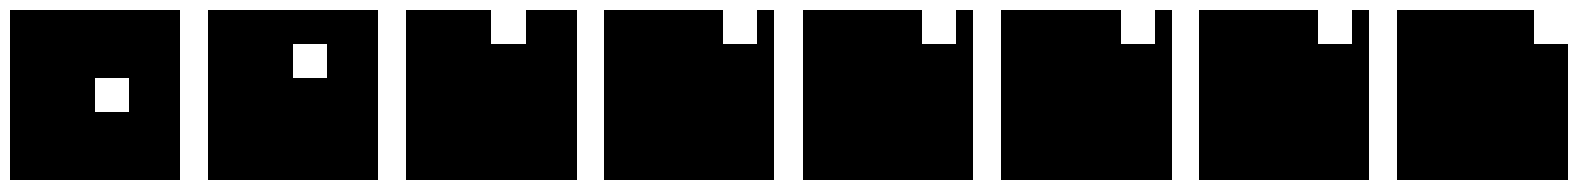

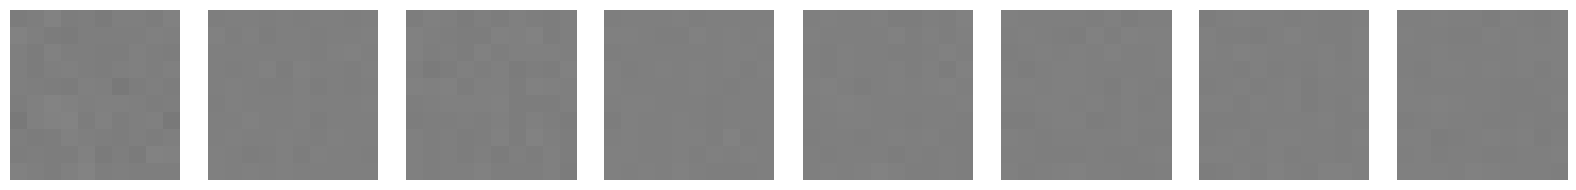

epoch 100: 117.88


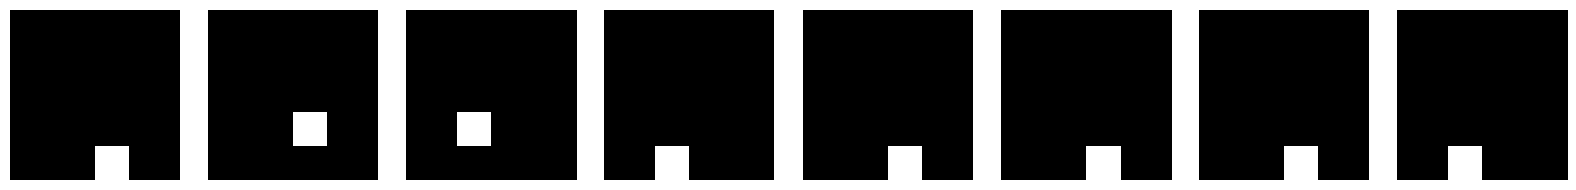

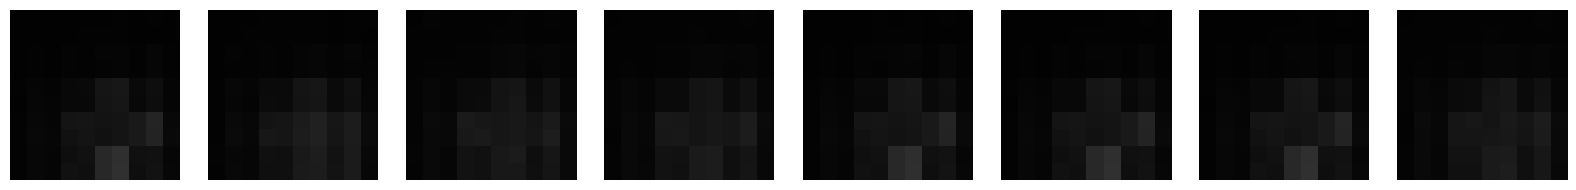

epoch 200: 69.55


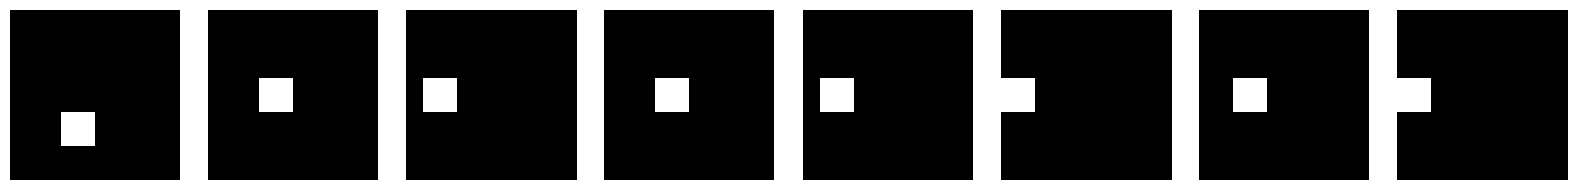

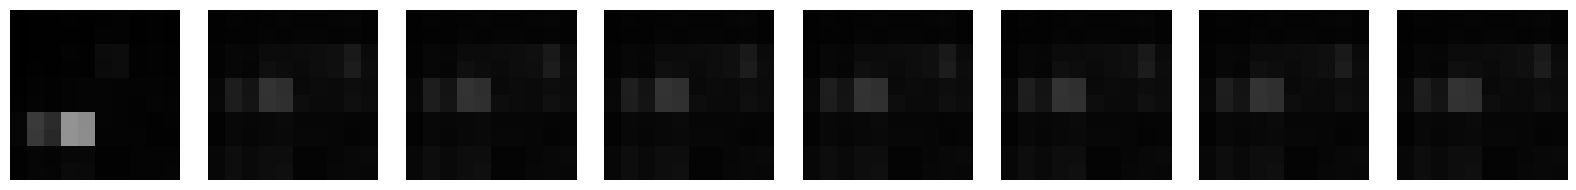

epoch 300: 64.41


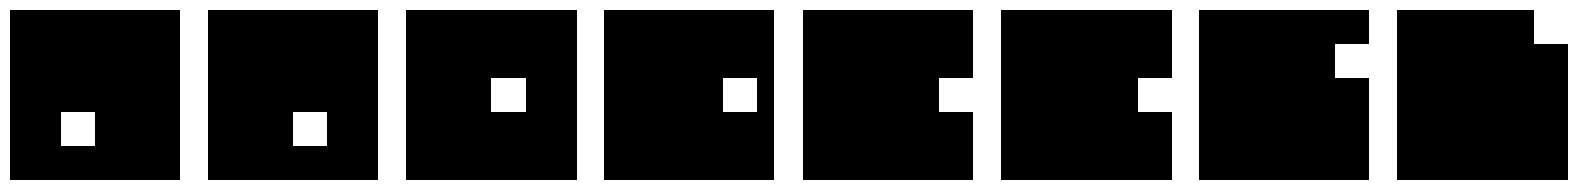

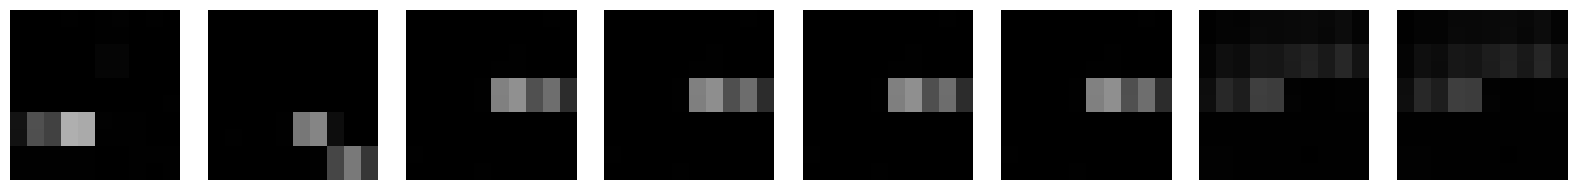

epoch 400: 58.45


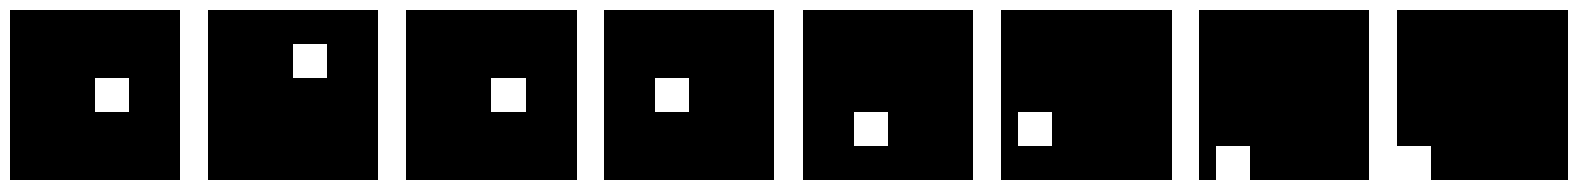

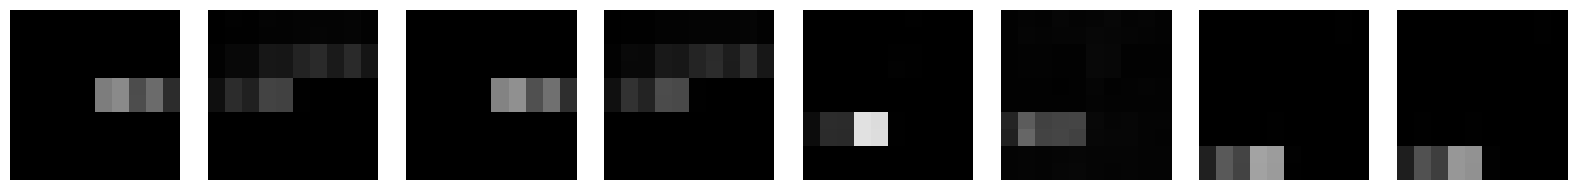

epoch 500: 52.39


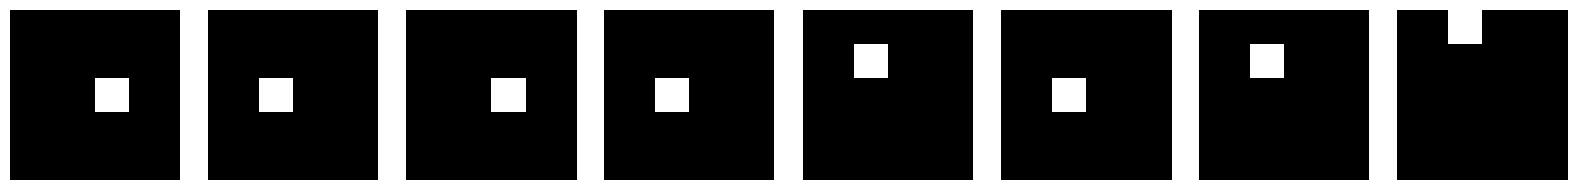

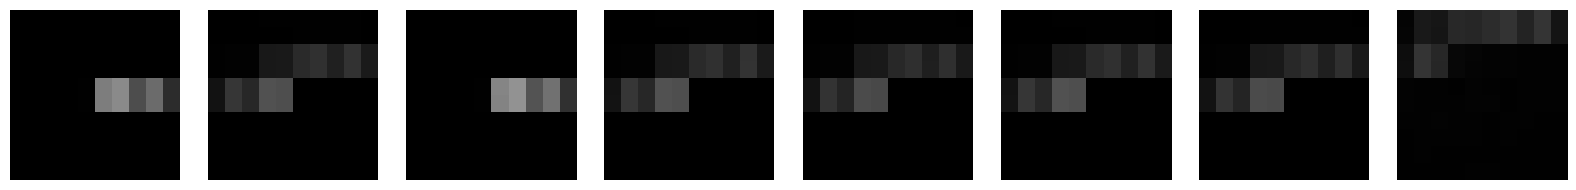

epoch 600: 52.42


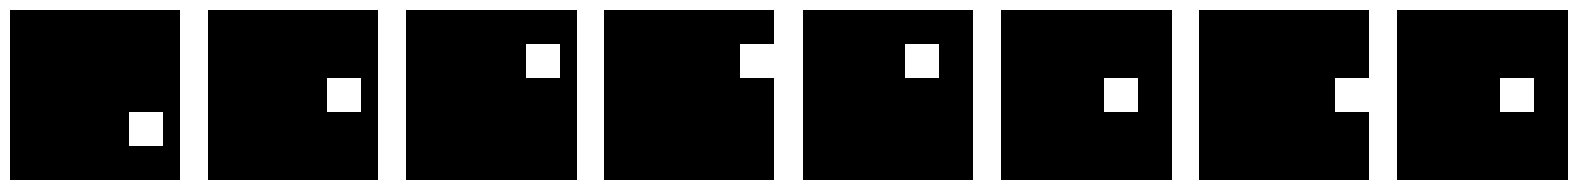

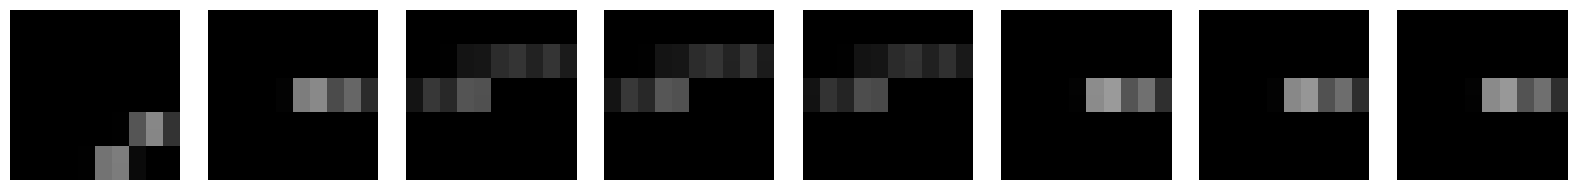

epoch 700: 45.59


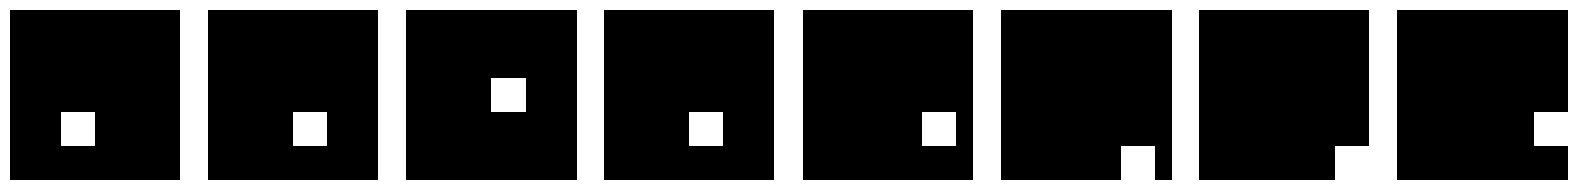

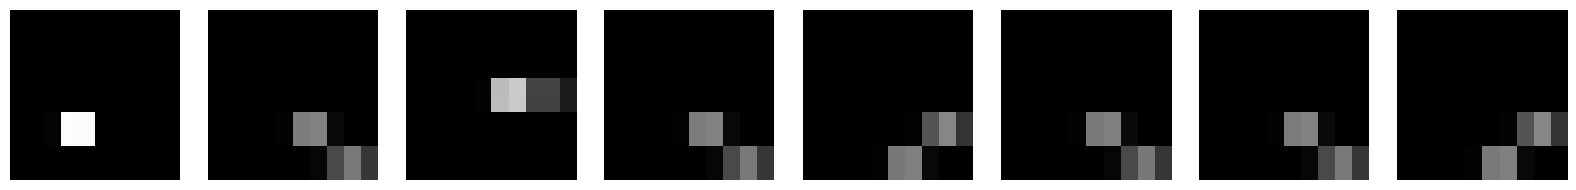

epoch 800: 38.58


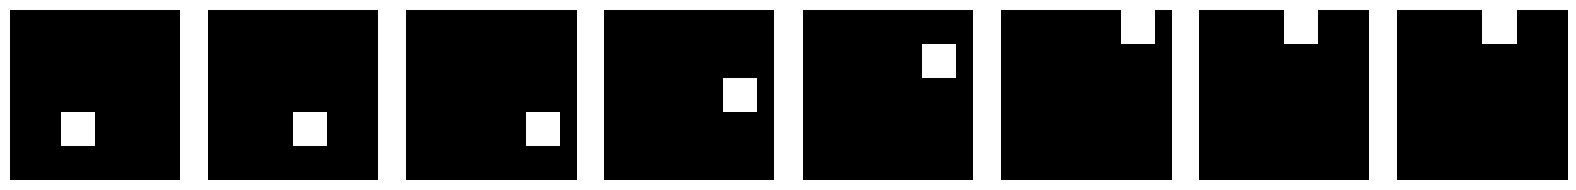

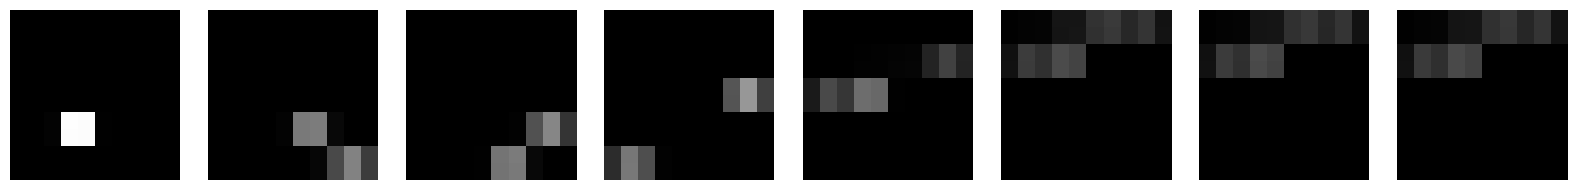

epoch 900: 38.25


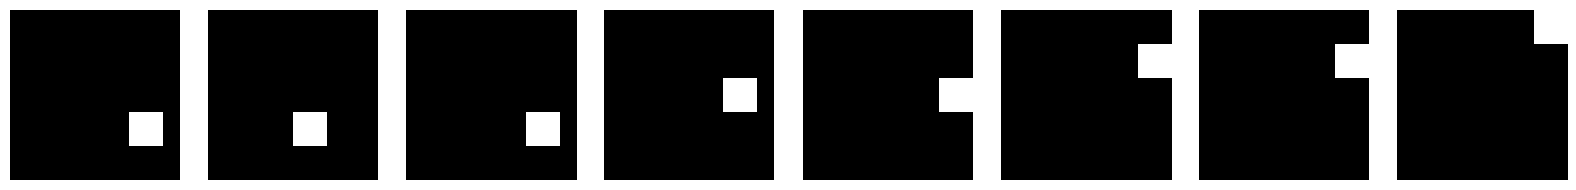

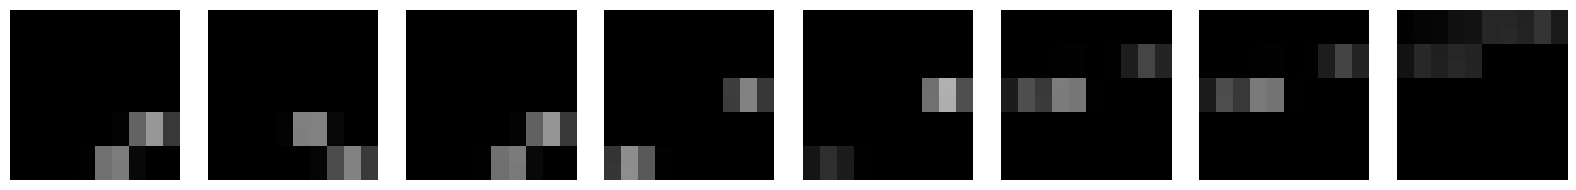

epoch 1000: 32.75


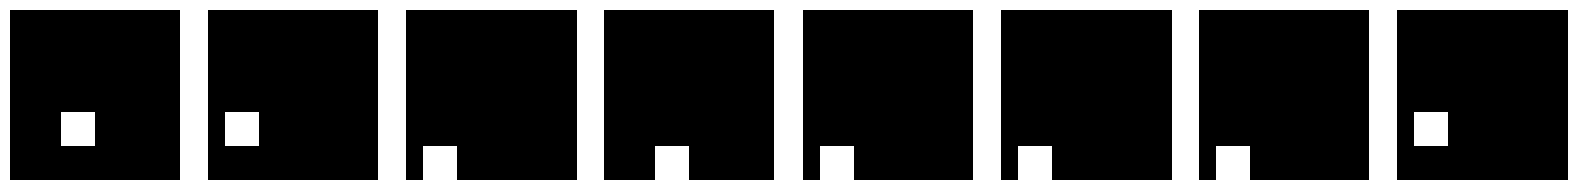

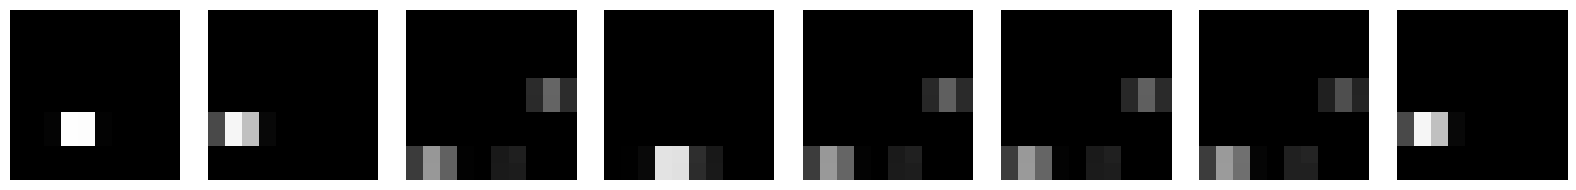

epoch 1100: 24.10


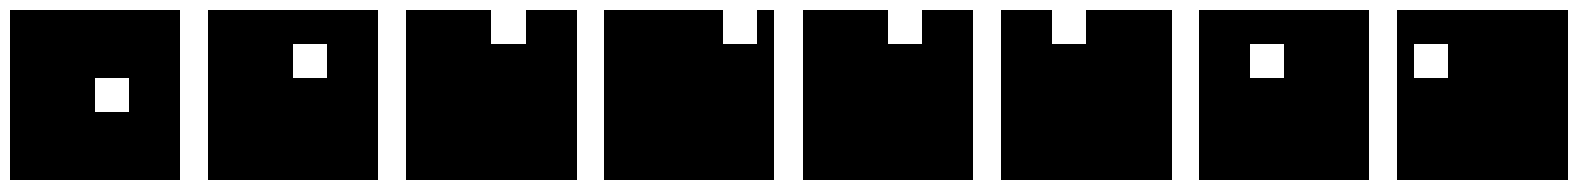

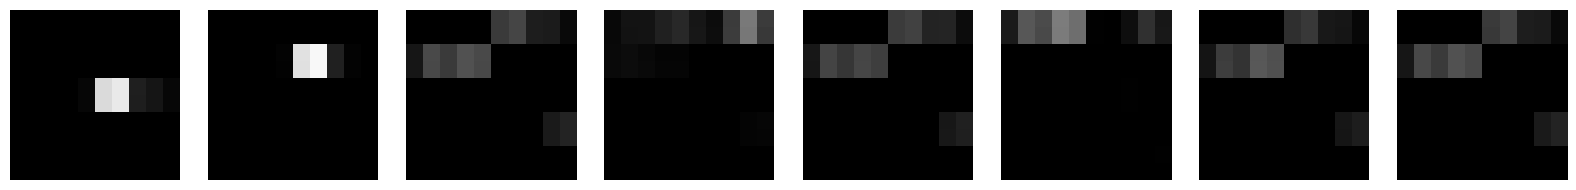

epoch 1200: 22.24


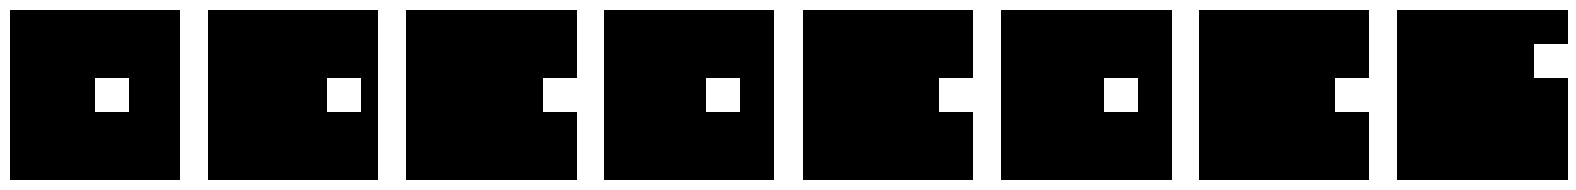

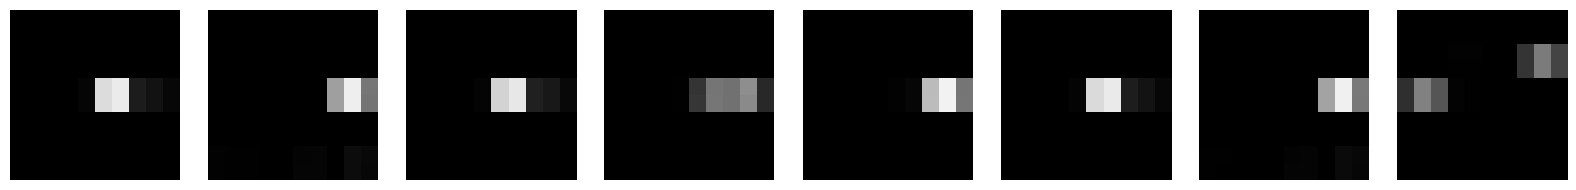

epoch 1300: 15.64


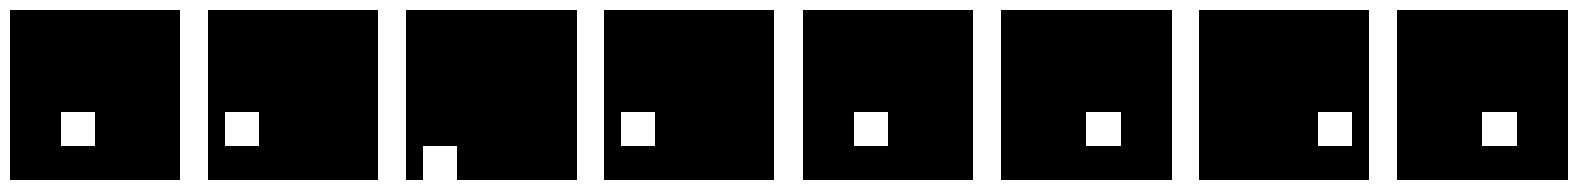

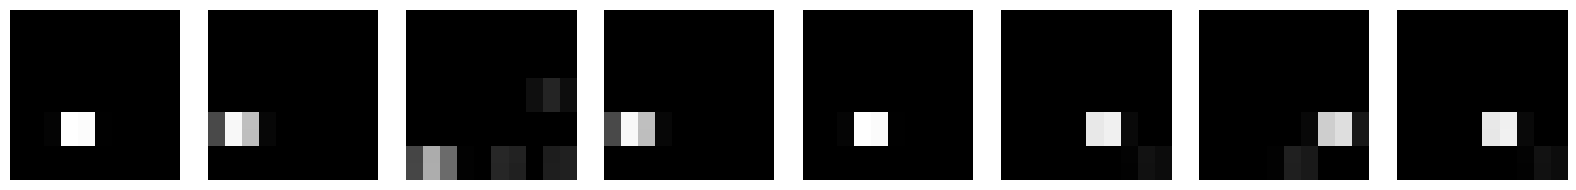

epoch 1400: 8.40


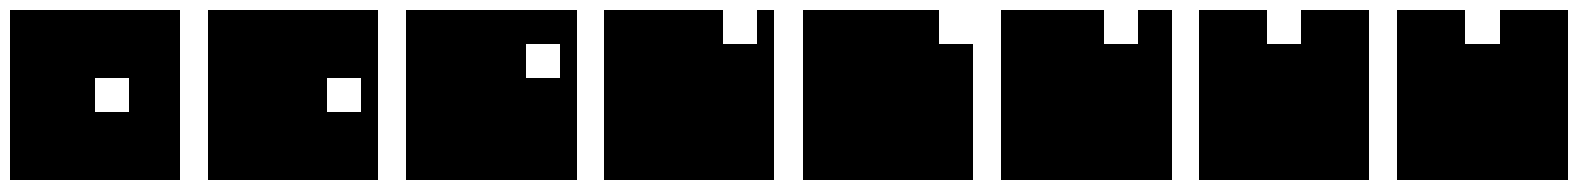

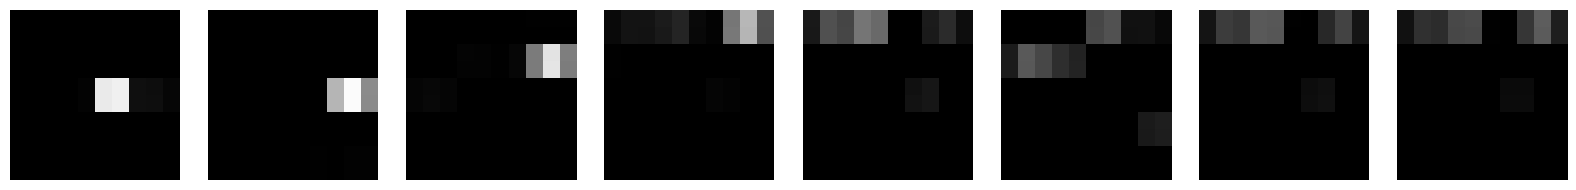

epoch 1500: 8.79


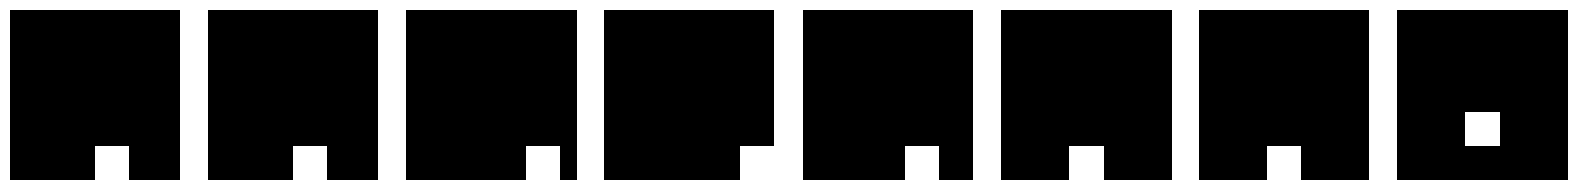

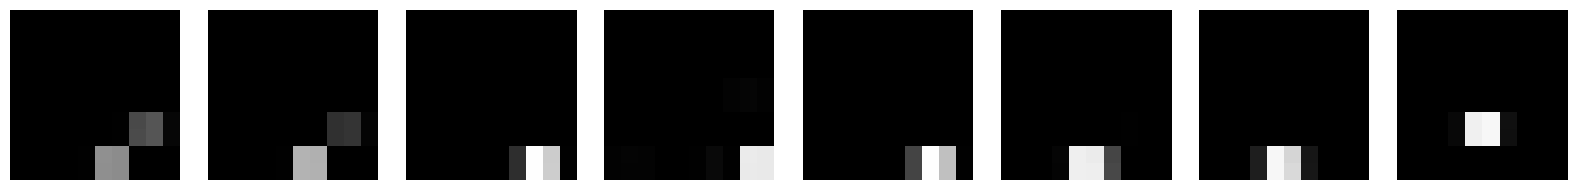

epoch 1600: 6.20


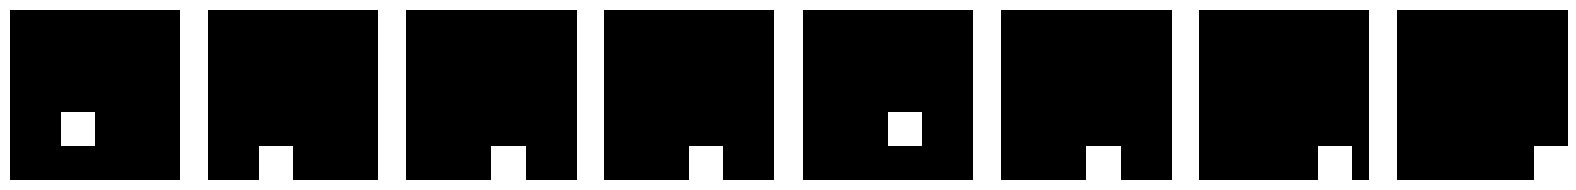

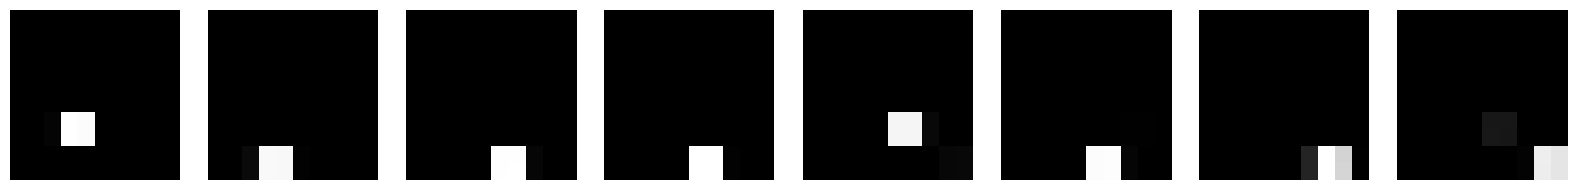

epoch 1700: 0.70


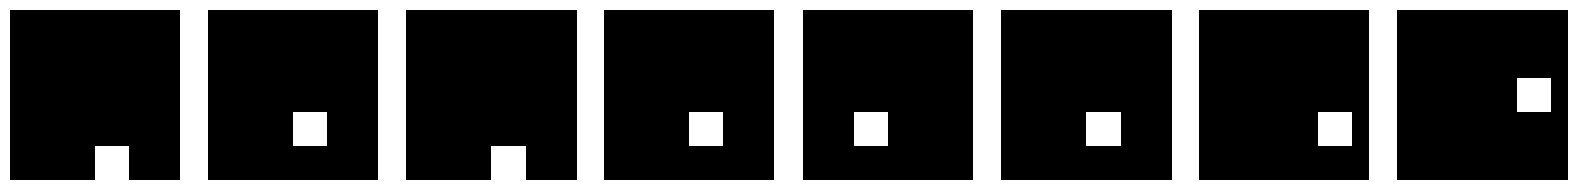

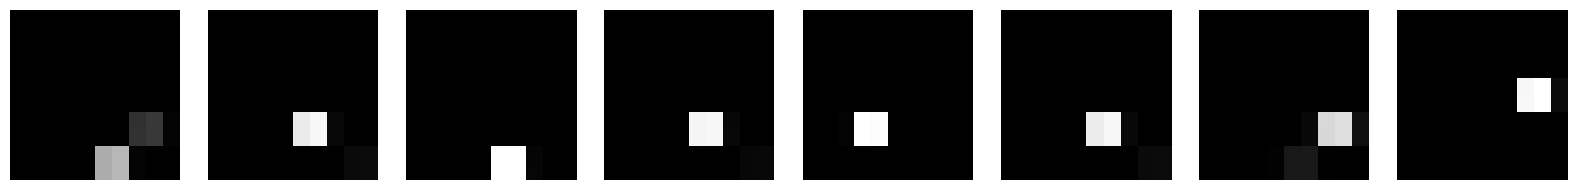

epoch 1800: 2.42


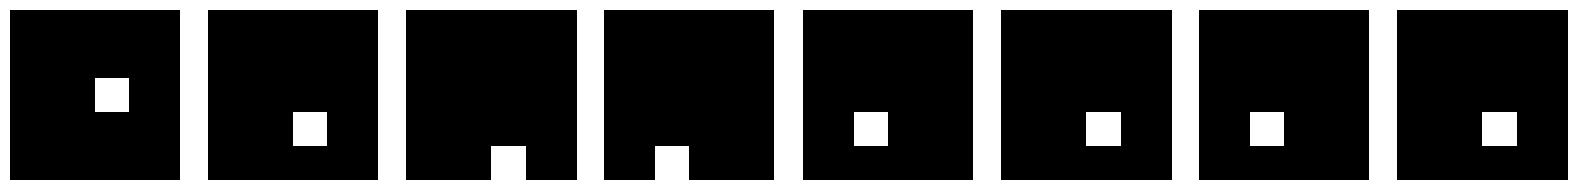

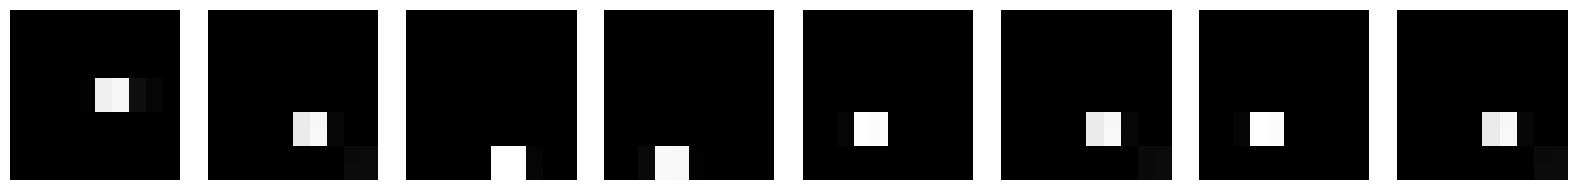

epoch 1900: 1.01


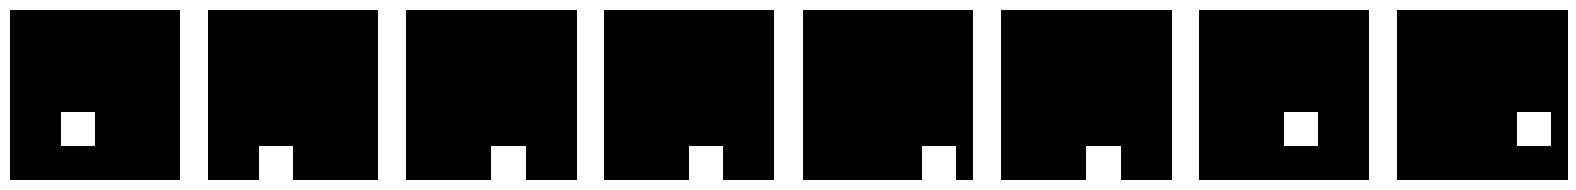

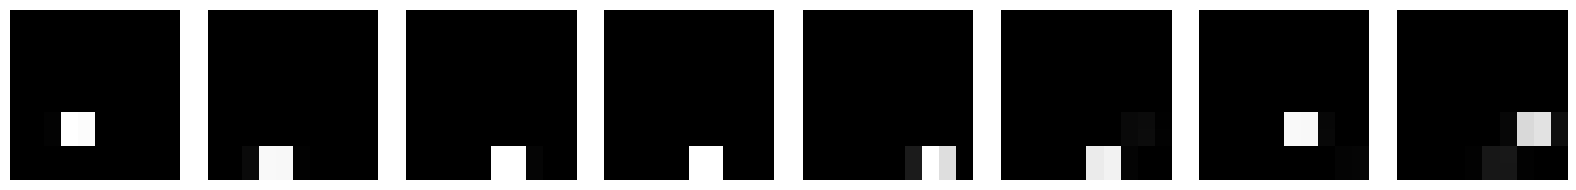

In [4]:
num_epochs = 2000
K, D = 50, 100

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, alpha=0.0)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_mlp(encoder_key, D, [(512, jax.nn.relu), (K, identity)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_mlp(decoder_key, K, [(512, jax.nn.relu), (D, jax.nn.sigmoid)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, alpha=0.0)
params = pgm_params, decoder_params, encoder_params

grad_key, key = jr.split(key)
gradfun = make_gradfun(grad_key, run_inference, encoder, loglike, pgm_prior_params, 1, num_samples, num_batches, 1e4)

optim = optax.adamw(learning_rate=1e-3)
opt_state = optim.init(params)

for epoch in range(num_epochs):
    grads, elbo = gradfun(params, get_batch(epoch))
    updates, opt_state = optim.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if epoch % 100 == 0:
        print(f"epoch {epoch}: {elbo:.2f}")
        test(params, data, env, key)

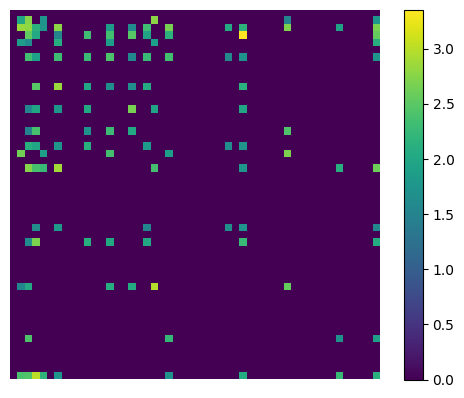

In [6]:
import matplotlib.pyplot as plt


clipped_params = jnp.where(jnp.abs(params[0][1]) < 1.5, 0.0, params[0][1])
plt.imshow(clipped_params)
plt.colorbar()
plt.axis('off')
plt.show()